# Cointegration x Multiple Linear Regression -> Markov Chain 

Feed multiple linear regression output into the transitional matrix for the Markov Chain transition probabilities between states.

In [9]:
pip install ta

  DEPRECATION: ta is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached ta-0.10.2.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for ta: started
  Running setup.py install for ta: finished with status 'done'


In [10]:
# Libaries 
# Libraries and Modules used
import MetaTrader5 as mt5 
import pandas as pd
from sklearn.linear_model import LinearRegression
import ta
import warnings
warnings.filterwarnings("ignore")
import numpy as np
# warnings.filterwarnings("ignore")
mt5.initialize()
# Replace following with your MT5 Account Login
account=51127988
password="Aar2frM7"
server = 'ICMarkets-Demo'

# Function to get rates from MT5 
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1['close']

## Cointegration Code

In [18]:
first_order_pairs = [('AUDJPY.a', 'EURJPY.a'), ('AUDJPY.a', 'GBPJPY.a'), ('EURJPY.a', 'GBPJPY.a'),                      
                    ('USDJPY.a', 'AUDJPY.a'), ('USDJPY.a', 'GBPJPY.a'), ('USDJPY.a', 'EURJPY.a'),                     
                    ('NZDJPY.a', 'AUDJPY.a'), ('NZDJPY.a', 'GBPJPY.a'), ('NZDJPY.a', 'EURJPY.a'), ('USDJPY.a', 'NZDJPY.a'),                      
                    ('AUDUSD.a', 'EURUSD.a'), ('AUDUSD.a', 'NZDUSD.a'), ('AUDUSD.a', 'GBPUSD.a'),                      
                    ('EURUSD.a', 'NZDUSD.a'), ('EURUSD.a', 'GBPUSD.a'), ('GBPUSD.a', 'NZDUSD.a'), 
                    ('AUDJPY.a', 'AUDUSD.a'), ('AUDUSD.a', 'AUDNZD.a'), ('EURUSD.a', 'EURJPY.a'),
                    ('EURGBP.a', 'GBPUSD.a'), ('GBPCHF.a', 'GBPUSD.a'), ('GBPCAD.a', 'GBPAUD.a'), 
                    ('CADJPY.a', 'AUDJPY.a'), ('CADJPY.a', 'NZDJPY.a'), ('EURNZD.a', 'GBPNZD.a')]

In [2]:
first_order_pairs = [('AUDUSD.a', 'NZDUSD.a'), 
                     ('EURUSD.a', 'GBPUSD.a'),
                     ('EURNZD.a', 'GBPNZD.a')]

In [14]:
from statsmodels.tsa.stattools import adfuller

def get_data(symbol, bars=6000):
    '''Fetches price data for a symbol'''
    rates = pd.DataFrame(mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_H4, 0, bars))
    rates['time'] = pd.to_datetime(rates['time'], unit = 's')
    return rates[['time', 'close']].set_index('time')

def compute_spread(pair):
    '''Computes the spread for a given pair'''
    data1 = get_data(pair[0])
    data2 = get_data(pair[1])
    merged = data1.join(data2, lsuffix="_x", rsuffix="_y")
    spread = merged['close_x'] - merged['close_y']
    return spread.dropna()

def adf_test(spread):
    '''Runs ADF test on a spread series'''
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}


In [15]:
# Running the tests
results = {}
for pair in first_order_pairs:
    print(f'Running through pair {pair}')
    spread = compute_spread(pair)
    results[pair] = adf_test(spread)

# Convert results to a DataFrame
df = pd.DataFrame(results).T

df

Running through pair ('AUDUSD.a', 'NZDUSD.a')
Running through pair ('EURUSD.a', 'GBPUSD.a')
Running through pair ('EURNZD.a', 'GBPNZD.a')


,,ADF Statistic,p-value,Critical Values
AUDUSD.a,NZDUSD.a,-2.824596,0.054845,"{'1%': -3.4314421710435847, '5%': -2.862022639..."
EURUSD.a,GBPUSD.a,-2.832464,0.053784,"{'1%': -3.4314449140748717, '5%': -2.862023851..."
EURNZD.a,GBPNZD.a,-2.978778,0.036924,"{'1%': -3.4314449140748717, '5%': -2.862023851..."


In [16]:
coint_pairs = []

for idx, row in df.iterrows():
    if row['ADF Statistic'] < row['Critical Values']['10%']:
        print(f'Pair {idx} is cointegrated')
        coint_pairs.append(idx)

Pair ('AUDUSD.a', 'NZDUSD.a') is cointegrated
Pair ('EURUSD.a', 'GBPUSD.a') is cointegrated
Pair ('EURNZD.a', 'GBPNZD.a') is cointegrated


## Multiple Linear Regression 

### Libraries and Functions

In [23]:
pip install pandas_ta

Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import scipy.optimize as opt
import pandas_ta as ta

In [25]:
def get_corresponding_pairs(currency_pair):
    base_currencies = [curr.split('USD')[0] for curr in currency_pair if 'USD' in curr]
    yen_pairs = [base + 'JPY.a' for base in base_currencies]
    usd_pairs = [base + 'USD.a' for base in base_currencies]
    return yen_pairs, usd_pairs

### Gathering Data

In [26]:
coint_dict = {}

for pair in coint_pairs:
    coint_dict[pair] = compute_spread(pair)

### Calculate Features

In [27]:
def lin_features(data):
    
    fiften_day_avg = data.rolling(window = 15).mean().round(5)
    sixty_day_avg = data.rolling(window= 60).mean().round(5)
    
    # Create DataFrame to store all features
    features_df = pd.DataFrame(index=data.index)
    
    # features_df['Yen Ver.'] =compute_spread(['EURJPY.a', 'GBPJPY.a']).shift(1).dropna()
    n = 10  # for example, you can adjust n as needed
    features_df['momentum'] = data - data.shift(n)
    features_df['fiften_day_avg'] = fiften_day_avg
    features_df['sixty_day_avg'] = sixty_day_avg
    features_df['RSI'] = ta.rsi(data, length=14)
    features_df['ROC'] = ((data - data.shift(n)) / data.shift(n)) * 100  # expressed in percentage
    
    # Remove rows with any NA values
    features_df.dropna(inplace=True)
    
    return features_df

features_dict = {}

for pair, data in coint_dict.items():
    pair_id = pair
    features = lin_features(data)
    features_dict[pair] = features

### Make Predictions

In [28]:
features

,momentum,fiften_day_avg,sixty_day_avg,RSI,ROC
time,,,,,
2020-02-24,-0.01383,-0.32424,-0.30625,45.022459,4.408952
2020-02-25,-0.01740,-0.32623,-0.30687,41.093199,5.468431
2020-02-26,0.00159,-0.32699,-0.30743,49.943517,-0.493819
2020-02-27,0.04321,-0.32683,-0.30753,59.301227,-12.634503
2020-02-28,0.05839,-0.32568,-0.30713,63.636143,-16.954615
...,...,...,...,...,...
2023-09-29,0.02003,-0.28254,-0.29394,62.528122,-6.864526
2023-10-02,0.01542,-0.28078,-0.29347,63.225831,-5.390854
2023-10-03,0.01586,-0.27933,-0.29285,61.243720,-5.500832


In [29]:
orders = {
    "buy": [],
    "sell": []
}
orders

{'buy': [], 'sell': []}

In [30]:
import datetime

# Define the objective function to minimize (MSE)
def objective(params):
    predicted = np.dot(X_test, params)
    mse = np.mean((predicted - y_test) ** 2)
    return mse

predictions_today = {} 
predictions_tomorrow = {} 
change_in_predictions = {}

current_datetime = datetime.datetime.now()
current_date_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')

def optimized_linear_regress():
    print('Beginning Optimized Standard Linear Regression')
    print('')
    for pair, features_df in features_dict.items():
        # Prepare the data
        X = features_df.values[:-2]  # Exclude last two values for today's and tomorrow's prediction
        y = coint_dict[pair].values[59:-2]  # Similarly, exclude the last two values 

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Optimization with basinhopping
        initial_params = np.ones(X_test.shape[1])
        result = opt.basinhopping(objective, initial_params, niter=100, stepsize=0.5)
        optimized_params = result.x

        # Using the optimized parameters to make predictions
        prediction_today = np.dot(features_df.iloc[-2, :].values, optimized_params)
        prediction_tomorrow = np.dot(features_df.iloc[-1, :].values, optimized_params)

        predictions_today[pair] = prediction_today
        predictions_tomorrow[pair] = prediction_tomorrow
        change_in_predictions[pair] = prediction_today - np.dot(features_df.iloc[-3, :].values, optimized_params)
        
    
    print(f"Time is {current_date_str}.")
    print('')
    for pair in predictions_today.keys():
        first_pair, second_pair = pair  # split the pair into individual currencies
        
        
        current_price = round(compute_spread(pair).iloc[-1], 5)
        print(f"For {pair}:")
        print(f"Today's prediction: {predictions_today[pair]:.5f}. Current price: {current_price}")
        
        if predictions_today[pair] > current_price:  # predicted spread is widening
            print(f"Signal: Sell {first_pair}, Buy {second_pair}")
            orders["sell"].append(first_pair)
            orders["buy"].append(second_pair)
        elif predictions_today[pair] < current_price:  # predicted spread is contracting
            print(f"Signal: Buy {first_pair}, Sell {second_pair}")
            orders["buy"].append(first_pair)
            orders["sell"].append(second_pair)
        # print(f"Tomorrow's prediction: {predictions_tomorrow[pair]:.5f}")
        # print(f"Change in prediction compared to yesterday: {change_in_predictions[pair]:.5f}")
        print("-----")

optimized_linear_regress()

Beginning Optimized Standard Linear Regression



NameError: name 'X_test' is not defined

### Send Orders

In [ ]:
def get_rates(pair1, tf, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, tf, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1['close']

def calc_hedge_ratio(x, y):
    Model2 = sm.OLS(x, y)
    Hedge_Ratio2 = Model2.fit()
    hedge_ratio_float2 = round(Hedge_Ratio2.params[0], 2)
    return hedge_ratio_float2

In [239]:
def send_order(symbol, side, lot, comment):
    
    if side.lower() == 'sell':
        order_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
    elif side.lower() == 'buy':
        order_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": order_type,
        "price": price,
        "deviation": 5,
        "magic": 234000,
        "comment": comment,
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    result

In [240]:
hedge_ratios = {}

for i in coint_pairs:
    x = get_rates(i[0], mt5.TIMEFRAME_D1, 1000)
    y = get_rates(i[1], mt5.TIMEFRAME_D1, 1000)
    hedge_ratios[i] = calc_hedge_ratio(x,y)

hedge_ratios

{('AUDUSD.a', 'NZDUSD.a'): 1.07,
 ('EURUSD.a', 'GBPUSD.a'): 0.87,
 ('EURNZD.a', 'GBPNZD.a'): 0.87}

In [243]:
lot = 1.00
for i in orders['sell']:
    send_order(i, 'sell', lot, 'S_Regress')
    
for i in orders['buy']:
    for key, val in hedge_ratios.items():
        if i in key:
            send_order(i, 'buy', lot * val, 'B_Regress')
        else: 
            continue

### Closing Logic

In [244]:
def close_position(position):

    tick = mt5.symbol_info_tick(position.symbol)

    request = {
        "action" : mt5.TRADE_ACTION_DEAL,
        "position": position.ticket,
        "symbol": position.symbol,
        "volume": position.volume,
        "type": mt5.ORDER_TYPE_BUY if position.type == 1 else mt5.ORDER_TYPE_SELL,
        "price": tick.ask if position.type == 1 else tick.bid,
        "deviation": 20,
        "magic": 100,
        "comment": 'Regres Close',
        'type_time': mt5.ORDER_TIME_GTC,
        'type_filling':mt5.ORDER_FILLING_IOC,

        }
    result = mt5.order_send(request)
    
def close_all():
    close_positions = []
    open_positions = mt5.positions_get()
    open_positions
    for i in open_positions:
        close_positions.append(i)
        
    for pos in close_positions:
        close_position(pos)

In [241]:
close_all()

### ARIMA + GARCH

**ARIMA Code**

In [275]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
plt.style.use('seaborn-darkgrid')

In [ ]:
    for pair in predictions_today.keys():
        first_pair, second_pair = pair  # split the pair into individual currencies
        
        
        current_price = round(compute_spread(pair).iloc[-1], 5)

In [386]:
for pair, data in coint_dict.items():
    print(f"Running through {pair}")
    first_pair, second_pair = pair
    current_price = round(compute_spread(pair).iloc[-1], 5)
    
    # Using the entire data to train the ARIMA model.
    
    model = ARIMA(data[:-1], order=(2, 1, 2))
    model_fit = model.fit()
    
    # Forecast the next step (today's prediction).
    forecast_results = model_fit.forecast()
    # print(forecast_results)
    prediction_today = round(forecast_results.iloc[0], 4)
    
    print(f"Prediction for today for {pair}: {prediction_today}. Current price - {current_price}")
    
    if predictions_today[pair] > current_price:  # predicted spread is widening
        print(f"Signal: Sell {first_pair}, Buy {second_pair}")
        orders["sell"].append(first_pair)
        orders["buy"].append(second_pair)
    elif predictions_today[pair] < current_price:  # predicted spread is contracting
        print(f"Signal: Buy {first_pair}, Sell {second_pair}")
        orders["buy"].append(first_pair)
        orders["sell"].append(second_pair)
        # print(f"Tomorrow's prediction: {predictions_tomorrow[pair]:.5f}")
        # print(f"Change in prediction compared to yesterday: {change_in_predictions[pair]:.5f}")
        print("-----")

Running through ('AUDUSD.a', 'NZDUSD.a')
Prediction for today for ('AUDUSD.a', 'NZDUSD.a'): 0.0392. Current price - 0.04236
Signal: Sell AUDUSD.a, Buy NZDUSD.a
Running through ('EURUSD.a', 'GBPUSD.a')
Prediction for today for ('EURUSD.a', 'GBPUSD.a'): -0.1612. Current price - -0.15998
Signal: Sell EURUSD.a, Buy GBPUSD.a
Running through ('EURNZD.a', 'GBPNZD.a')
Prediction for today for ('EURNZD.a', 'GBPNZD.a'): -0.2724. Current price - -0.27119
Signal: Sell EURNZD.a, Buy GBPNZD.a


In [ ]:
        if predictions_today[pair] > current_price:  # predicted spread is widening
            print(f"Signal: Sell {first_pair}, Buy {second_pair}")
            orders["sell"].append(first_pair)
            orders["buy"].append(second_pair)
        elif predictions_today[pair] < current_price:  # predicted spread is contracting
            print(f"Signal: Buy {first_pair}, Sell {second_pair}")
            orders["buy"].append(first_pair)
            orders["sell"].append(second_pair)
        # print(f"Tomorrow's prediction: {predictions_tomorrow[pair]:.5f}")
        # print(f"Change in prediction compared to yesterday: {change_in_predictions[pair]:.5f}")
        print("-----")

In [299]:
for pair, data in coint_dict.items():
    print(f"Running through {pair}")
    
    predictions = []

    # Iterate through combinations of AR and MA values
    for p in range(10):
        for q in range(10):
            try:
                model = ARIMA(data[:-1], order=(p, 1, q))
                model_fit = model.fit()
                forecast = model_fit.forecast()[0]
                predictions.append(forecast[0])
            except:
                # In case certain AR and MA combinations lead to errors, we skip those combinations.
                continue

    # Average the predictions if possible, otherwise display a message.
    if len(predictions) > 0:
        prediction_today = round(sum(predictions) / len(predictions), 4)
        print(f"Prediction for today for {pair}: {prediction_today}")
    else:
        print(f"No predictions could be made for {pair}.")

Running through ('AUDUSD.a', 'NZDUSD.a')
No predictions could be made for ('AUDUSD.a', 'NZDUSD.a').
Running through ('EURUSD.a', 'GBPUSD.a')
No predictions could be made for ('EURUSD.a', 'GBPUSD.a').
Running through ('EURNZD.a', 'GBPNZD.a')
No predictions could be made for ('EURNZD.a', 'GBPNZD.a').


**GARCH Code**

### Other Technical Analyis tools

In [ ]:
# Moving Averages 

In [ ]:
# SMC Scores

### Markov Chain

In [382]:
# Calculating Features #

def nn_calc_features(pair1, pair2, timeframe, x):
    # You'll need to fetch pair1's data in a similar manner as pair2
    # Assuming pair1 is fetched similarly as below
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair2 = pd.DataFrame(mt5.copy_rates_from_pos(pair2, timeframe, 0, x))
    df = pair1[['open', 'high', 'low', 'close']] - pair2[['open', 'high', 'low', 'close']]
    
    fiften_day_avg = df['close'].rolling(window = 15).mean().round(5)
    sixty_day_avg =  df['close'].rolling(window= 60).mean().round(5)
    
    df['fiften_day_avg'] = fiften_day_avg
    df['sixty_day_avg'] = sixty_day_avg
    
    return df.dropna()

nn_features = {}
for pair in coint_dict.keys():
    pair1 = pair[0]
    pair2 = pair[1]
    diff = nn_calc_features(pair1, pair2, mt5.TIMEFRAME_D1, 1000)
    nn_features[pair] = diff

In [366]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.cluster import KMeans

def train_neural_network(dataframe):
    n_features = dataframe.shape[1]
    X_train = dataframe.drop(columns='close')
    y_train = dataframe['close']

    # 1. Train a simple neural network
    model = Sequential()
    model.add(Input(shape=(n_features-1,))) # Excluding 'close' column
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))  # We'll extract activations from this layer
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # 2. Extract activations from the second last layer
    activation_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    activations = activation_model.predict(X_train)

    # 3. Cluster on these activations
    n_states = 5  # or whatever number you think is appropriate
    kmeans = KMeans(n_clusters=n_states).fit(activations)
    return kmeans.labels_  # Return the states

states_dict = {}

for pair, dataframe in nn_features.items():
    print(f"{pair}: shape - {dataframe.shape}, type - {type(dataframe)}")

for pair, dataframe in nn_features.items():
    print(f"Running neural network for {pair}")
    states = train_neural_network(dataframe)
    states_dict[pair] = states

('AUDUSD.a', 'NZDUSD.a'): shape - (941, 6), type - <class 'pandas.core.frame.DataFrame'>
('EURUSD.a', 'GBPUSD.a'): shape - (941, 6), type - <class 'pandas.core.frame.DataFrame'>
('EURNZD.a', 'GBPNZD.a'): shape - (941, 6), type - <class 'pandas.core.frame.DataFrame'>
Running neural network for ('AUDUSD.a', 'NZDUSD.a')
Epoch 1/100
30/30 [==============================] - 1s 1ms/step - loss: 2.3790e-04
Epoch 2/100
30/30 [==============================] - 0s 1ms/step - loss: 2.0411e-05
Epoch 3/100
30/30 [==============================] - 0s 1ms/step - loss: 6.6758e-06
Epoch 4/100
30/30 [==============================] - 0s 1ms/step - loss: 3.4814e-06
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 2.9692e-06
Epoch 6/100
30/30 [==============================] - 0s 1ms/step - loss: 2.5910e-06
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 2.3643e-06
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 2.2964e-06
Epoch 9/1

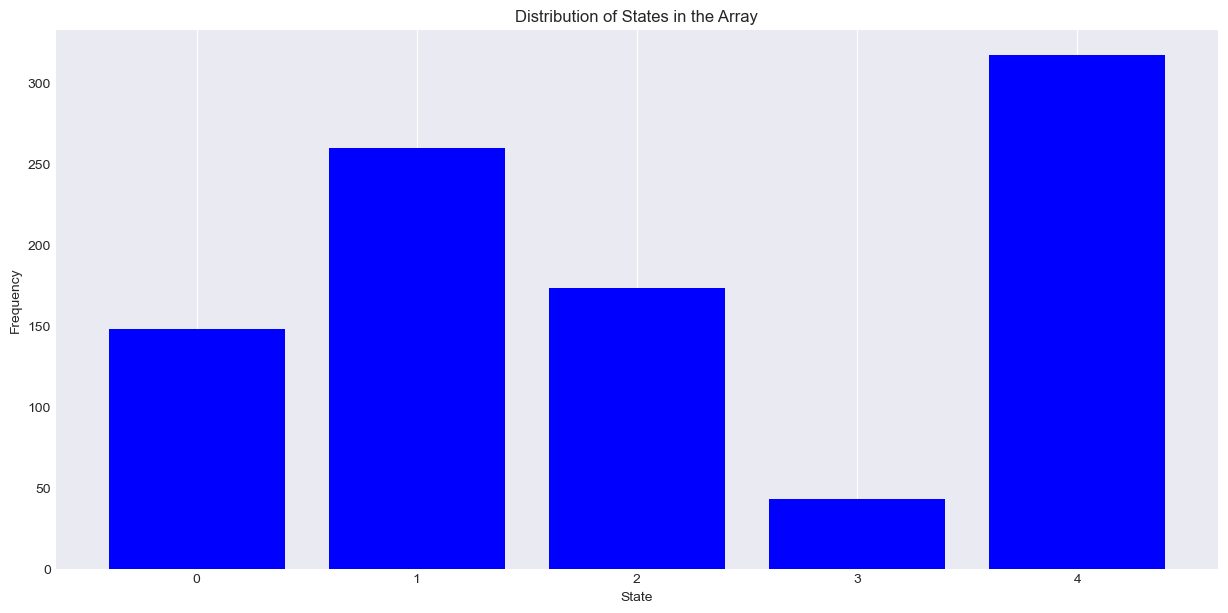

In [379]:
data = states_dict['AUDUSD.a', 'NZDUSD.a']

unique, counts = np.unique(data, return_counts=True)

plt.bar(unique, counts, color='blue', align='center')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Distribution of States in the Array')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

In [380]:
for u, c in zip(unique, counts):
    print(f"State {u}: {c} occurrences, {c/len(data)*100:.2f}%")

State 0: 148 occurrences, 15.73%
State 1: 260 occurrences, 27.63%
State 2: 173 occurrences, 18.38%
State 3: 43 occurrences, 4.57%
State 4: 317 occurrences, 33.69%


In [136]:
class MarkovChain:
    
    # Adjust Accordingly 
    def __init__(self, price_data):
        self.data = pd.DataFrame(price_data)
        self.states = ['s_bull', 'w_bull', 'doji', 'w_bear', 's_bear']
    
    def compute_returns(self):
        self.data['returns'] = self.data['close'].pct_change()
        
    # Temporary states, to amend to more sophisticated/specific states
    def classify_state(self, ret):
        if ret > 0.01:
            return 's_bull'
        elif ret > 0.003 and ret < 0.01:
            return 'w_bull'
        elif ret < 0.002 and ret > -0.002:
            return 'doji'
        elif ret < -0.003 and ret > -0.01:
            return 'w_bear'
        else:
            return 's_bear'
        
    def classify_states(self):
        self.data['state'] = self.data['returns'].apply(self.classify_state)
        
        
    # ChatGPT code testing/creating a matrix to test for ergodicity 
    def initialize_matrix(self):
        self.matrix = np.zeros((len(self.states), len(self.states)))

    def construct_transition_matrix(self):
        self.initialize_matrix()

        for i in range(1, len(self.data['state'])):
            curr_state = self.data['state'][i]
            prev_state = self.data['state'][i - 1]
            curr_index = self.states.index(curr_state)
            prev_index = self.states.index(prev_state)

            self.matrix[prev_index][curr_index] += 1

        # Normalize the matrix to get transition probabilities
        self.matrix = self.matrix / self.matrix.sum(axis=1)[:, None]

    def is_ergodic(self):
        if (self.matrix > 0).all():
            return True
        return False

In [134]:
data = get_rates("EURUSD.a", mt5.TIMEFRAME_D1, 500)
data

0      1.16066
1      1.15793
2      1.16127
3      1.15545
4      1.15675
        ...   
495    1.05719
496    1.05031
497    1.05661
498    1.05732
499    1.05700
Name: close, Length: 500, dtype: float64

In [135]:
a = MarkovChain(data)
a.compute_returns()
a.classify_states()
a.data

,close,returns,state
0,1.16066,NaN,s_bear
1,1.15793,-0.002352,s_bear
2,1.16127,0.002884,s_bear
3,1.15545,-0.005012,w_bear
4,1.15675,0.001125,doji
...,...,...,...
495,1.05719,-0.001907,doji
496,1.05031,-0.006508,w_bear
497,1.05661,0.005998,w_bull
498,1.05732,0.000672,doji


In [390]:
class TradeSignalMarkovChain():

    def __init__(self, price_data, trade_signals):
        super().__init__(price_data)
        self.trade_signals = trade_signals

    # def integrate_trade_signals(self):
        # Code to integrate trade signals to compute transitions